# Contrastive Language-Image Pretraining

[Paper here](https://arxiv.org/pdf/2103.00020)


In [1]:
# %cd "Deep-Learning-From-Scratch/Transformers/CLIP/"

In [2]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [3]:
import os
import random
import itertools
# import wandb
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision.utils import make_grid

from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# wandb.require('core')
# wandb.login()

In [5]:
# Hyperparameters
D_IMG_MODEL = 2048
D_TEXT_MODEL = 768
D_EMBD = 512
IMAGE_SHAPE = (3, 224, 224)
TOKENIZER_MAX_LEN = 200
TEMPERATURE = 1
DROPOUT = 0.1

BATCH_SIZE = 32
N_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3

## Load the dataset


In [6]:
with open("./data/Flickr8k.token.txt") as f:
    captions = f.read().splitlines()

captions[:10]


[
    '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
    '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
    '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
    '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
    '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
    '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
    '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
    '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
    '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
    '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .'
]

In [7]:
captions_dict = {}

for line in captions:
    contents = line.split("\t")

    if len(contents) < 2:
        continue

    filename, caption = contents[0], contents[1]

    filename = filename[:-2]

    if filename in captions_dict.keys():
        captions_dict[filename].append(caption)
    else:
        captions_dict[filename] = [caption]

In [8]:
def get_split_ids(split):
    with open(f"./data/Flickr_8k.{split}Images.txt") as f:
        return f.read().splitlines()


train_ids = get_split_ids("train")
val_ids = get_split_ids("dev")
test_ids = get_split_ids("test")

In [9]:
class ImageTextDataset(Dataset):
    def __init__(self, tokenizer, target_size, split_ids, max_length=200):
        super().__init__()

        self.tokenizer = tokenizer
        self.target_size = target_size
        self.max_length = max_length
        self.image_ids = split_ids

        self.transforms = v2.Compose(
            [
                v2.Resize(target_size),
                v2.ToImage(),
                v2.ToDtype(dtype=torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

        self.images, self.captions = self.fetch_dataset()
        self.encoded_captions = self.tokenizer(
            self.captions,
            max_length=self.max_length,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

    def fetch_dataset(self):
        images = [id for id in self.image_ids]

        random.seed(42)

        captions = [random.choice(captions_dict[id]) for id in self.image_ids]

        return images, captions

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encoded_captions.items()}

        image_id = self.images[index]

        image = Image.open(f"./data/Flicker8k_Dataset/{image_id}").convert("RGB")
        image = self.transforms(image)

        item["image"] = image
        item["caption"] = self.captions[index]

        return item

In [10]:
def reverse_transform(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1)

    x = x * std + mean

    return v2.ToPILImage()(x)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_dataset = ImageTextDataset(
    tokenizer=tokenizer,
    target_size=IMAGE_SHAPE[1:],
    split_ids=train_ids,
    max_length=TOKENIZER_MAX_LEN,
)
val_dataset = ImageTextDataset(
    tokenizer=tokenizer,
    target_size=IMAGE_SHAPE[1:],
    split_ids=val_ids,
    max_length=TOKENIZER_MAX_LEN,
)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
sample_items = next(iter(val_loader))

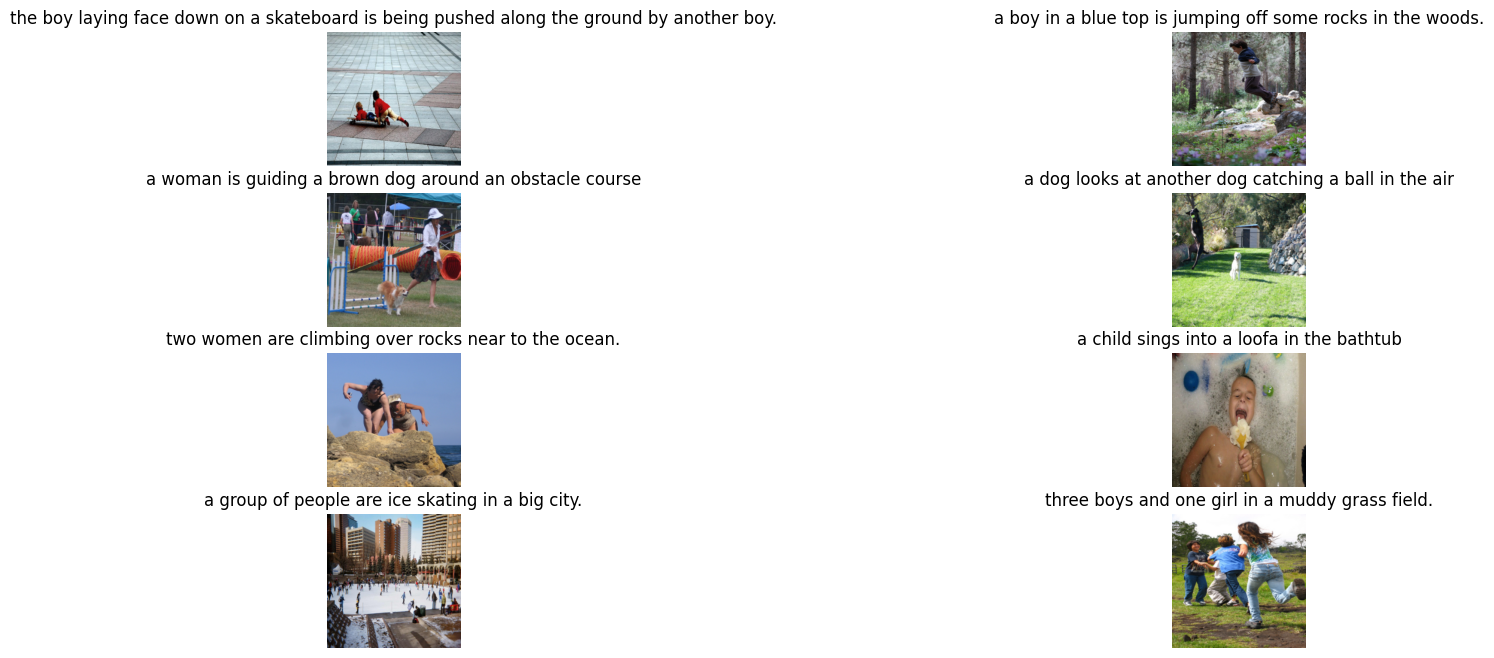

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(20, 8))
for idx in range(8):
    img = sample_items["image"][idx]
    label = sample_items["input_ids"][idx]

    img = reverse_transform(img)
    ax = axs[idx // 2, idx % 2]
    ax.imshow(img)
    ax.set_title(tokenizer.decode(label, skip_special_tokens=True))
    ax.axis("off")

plt.show()

## Build the architecture

In [15]:
class ImageEncoder(nn.Module):
    def __init__(self, trainable=False, debug=False):
        super().__init__()

        self.model = torchvision.models.resnet50(
            weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
        )

        # Remove the classification head
        self.model.fc = nn.Identity()

        for param in self.model.parameters():
            param.requires_grad = trainable

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[IMG ENCODER] Input")
        x = self.model(x)
        self._debug_print(x, "[IMG ENCODER] Output")

        return x


In [16]:
ImageEncoder(debug=True)(sample_items["image"])

[IMG ENCODER] Input: torch.Size([32, 3, 224, 224])

[IMG ENCODER] Output: torch.Size([32, 2048])


tensor([[2.6951e-03, 0.0000e+00, 3.1090e-02,  ..., 0.0000e+00, 0.0000e+00,
         7.5388e-02],
        [0.0000e+00, 6.4130e-01, 5.7394e-02,  ..., 1.5765e-02, 7.3508e-01,
         1.1454e-01],
        [3.1854e-02, 3.3975e-03, 2.8369e-01,  ..., 0.0000e+00, 0.0000e+00,
         1.4544e-01],
        ...,
        [1.0458e-01, 3.5771e-02, 6.9577e-02,  ..., 0.0000e+00, 1.0164e-03,
         0.0000e+00],
        [0.0000e+00, 3.5256e-01, 6.4991e-03,  ..., 6.1911e-02, 1.4099e-01,
         7.7110e-02],
        [5.9966e-02, 1.7137e-02, 2.3015e-01,  ..., 1.1666e-01, 0.0000e+00,
         1.2165e+00]])

In [17]:
class TextEncoder(nn.Module):
    def __init__(self, trainable=False, debug=False):
        super().__init__()

        self.model = AutoModel.from_pretrained("distilbert-base-uncased")

        for param in self.model.parameters():
            param.requires_grad = trainable

        self.debug = debug

        self.cls_token_idx = 0

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, attn_mask=None):
        self._debug_print(x, "[TEXT ENCODER] Input")
        x = self.model(input_ids=x, attention_mask=attn_mask)
        x = x.last_hidden_state[:, self.cls_token_idx, :]
        self._debug_print(x, "[TEXT ENCODER] Output")
        return x


In [18]:
TextEncoder(debug=True)(sample_items["input_ids"])

[TEXT ENCODER] Input: torch.Size([32, 36])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[TEXT ENCODER] Output: torch.Size([32, 768])


tensor([[-0.3407, -0.3769,  0.0314,  ...,  0.0106,  0.5120,  0.2326],
        [-0.2544, -0.4293, -0.0236,  ...,  0.0998,  0.4976,  0.1457],
        [-0.4085, -0.3532,  0.1145,  ..., -0.0969,  0.2492,  0.3024],
        ...,
        [-0.1947, -0.3675,  0.0793,  ..., -0.0409,  0.6214,  0.0587],
        [-0.1965, -0.3396, -0.0382,  ...,  0.0292,  0.5836, -0.0293],
        [-0.2056, -0.3854,  0.0802,  ..., -0.0035,  0.5011,  0.2106]])

In [19]:
class Projection(nn.Module):
    def __init__(self, d_model, d_embd, dropout=0.0, debug=False):
        super().__init__()

        self.projection = nn.Linear(d_model, d_embd)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(d_embd, d_embd),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_embd)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[PROJECTION] Input")
        projected = self.projection(x)
        self._debug_print(projected, "[PROJECTION] Projected")
        x = self.fc(projected)
        self._debug_print(x, "[PROJECTION] FC")
        x += projected
        x = self.layer_norm(x)
        self._debug_print(x, "[PROJECTION] Output")
        return x


In [20]:
Projection(d_model=768, d_embd=512, debug=True)(
    TextEncoder()(sample_items["input_ids"])
)

[PROJECTION] Input: torch.Size([32, 768])

[PROJECTION] Projected: torch.Size([32, 512])

[PROJECTION] FC: torch.Size([32, 512])

[PROJECTION] Output: torch.Size([32, 512])


tensor([[ 0.5977,  0.7884, -0.9541,  ...,  0.5987, -0.9817,  0.0477],
        [ 0.1305,  0.9544, -0.9423,  ...,  0.7907, -1.0462,  0.2032],
        [ 0.2438,  0.5275, -1.4252,  ...,  0.7380, -0.8105,  0.6984],
        ...,
        [ 0.6050,  0.8269, -0.7028,  ...,  0.9827, -1.4693,  0.6898],
        [ 0.6279,  1.2532, -0.8981,  ...,  1.0572, -1.7712,  0.4360],
        [ 0.1690,  1.3061, -0.5859,  ...,  0.5624, -0.8538,  0.3043]],
       grad_fn=<NativeLayerNormBackward0>)

In [21]:
Projection(d_model=2048, d_embd=512, debug=True)(
    ImageEncoder()(sample_items["image"])
)

[PROJECTION] Input: torch.Size([32, 2048])

[PROJECTION] Projected: torch.Size([32, 512])

[PROJECTION] FC: torch.Size([32, 512])

[PROJECTION] Output: torch.Size([32, 512])


tensor([[ 0.7956, -0.2936,  0.4618,  ..., -1.0384, -0.0160, -2.1602],
        [ 0.4784,  0.2847,  0.5476,  ...,  0.5655,  1.1873, -0.1959],
        [ 1.4169, -0.1051, -0.9503,  ...,  0.0179,  0.2196, -0.8516],
        ...,
        [ 0.8678,  1.5989, -0.2496,  ...,  0.2494, -0.6153, -1.6025],
        [-0.4962, -0.0566, -0.0573,  ..., -1.1378, -0.8460, -2.5292],
        [ 0.9017, -0.1817,  1.0212,  ..., -0.4062, -1.1624, -1.7140]],
       grad_fn=<NativeLayerNormBackward0>)

In [22]:
class CLIP(nn.Module):
    def __init__(
        self, d_img_model, d_text_model, d_embd, temp, trainable=False, debug=False
    ):
        super().__init__()

        self.image_encoder = ImageEncoder(trainable=trainable, debug=debug)
        self.text_encoder = TextEncoder(trainable=trainable, debug=debug)

        self.image_projection = Projection(
            d_model=d_img_model, d_embd=d_embd, debug=debug
        )
        self.text_projection = Projection(
            d_model=d_text_model, d_embd=d_embd, debug=debug
        )

        self.temperature = temp
        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, image, input_ids, attn_mask=None):
        self._debug_print(image, "[CLIP] Image Input")
        self._debug_print(input_ids, "[CLIP] Text Input")

        image_features = self.image_encoder(image)
        text_features = self.text_encoder(input_ids, attn_mask)

        self._debug_print(image_features, "[CLIP] Image Features")
        self._debug_print(text_features, "[CLIP] Text Features")

        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        self._debug_print(image_embeddings, "[CLIP] Image Embeddings")
        self._debug_print(text_embeddings, "[CLIP] Text Embeddings")

        logits = (image_embeddings @ text_embeddings.T) / self.temperature
        self._debug_print(logits, "[CLIP] Logits")

        image_similarity = image_embeddings @ image_embeddings.T
        text_similarity = text_embeddings @ text_embeddings.T

        targets = F.softmax(
            (image_similarity + text_similarity) / 2 * self.temperature, dim=-1
        )
        image_loss = (-targets.T * self.log_softmax(logits.T)).sum(1)
        text_loss = (-targets * self.log_softmax(logits)).sum(1)

        loss = (image_loss + text_loss) / 2.0

        return loss.mean()


In [23]:
CLIP(
    d_img_model=D_IMG_MODEL,
    d_text_model=D_TEXT_MODEL,
    d_embd=D_EMBD,
    temp=1.0,
    debug=True,
)(sample_items["image"], sample_items["input_ids"], sample_items["attention_mask"])


[CLIP] Image Input: torch.Size([32, 3, 224, 224])

[CLIP] Text Input: torch.Size([32, 36])

[IMG ENCODER] Input: torch.Size([32, 3, 224, 224])

[IMG ENCODER] Output: torch.Size([32, 2048])

[TEXT ENCODER] Input: torch.Size([32, 36])

[TEXT ENCODER] Output: torch.Size([32, 768])

[CLIP] Image Features: torch.Size([32, 2048])

[CLIP] Text Features: torch.Size([32, 768])

[PROJECTION] Input: torch.Size([32, 2048])

[PROJECTION] Projected: torch.Size([32, 512])

[PROJECTION] FC: torch.Size([32, 512])

[PROJECTION] Output: torch.Size([32, 512])

[PROJECTION] Input: torch.Size([32, 768])

[PROJECTION] Projected: torch.Size([32, 512])

[PROJECTION] FC: torch.Size([32, 512])

[PROJECTION] Output: torch.Size([32, 512])

[CLIP] Image Embeddings: torch.Size([32, 512])

[CLIP] Text Embeddings: torch.Size([32, 512])

[CLIP] Logits: torch.Size([32, 32])

tensor(25.1664, grad_fn=<MeanBackward0>)

## Train the model

In [24]:
model = CLIP(
    d_img_model=D_IMG_MODEL,
    d_text_model=D_TEXT_MODEL,
    d_embd=D_EMBD,
    temp=TEMPERATURE,
    trainable=True,
    debug=False,
).to(device)

params = [
    {"params": model.image_encoder.parameters(), "lr": LEARNING_RATE},
    {"params": model.text_encoder.parameters(), "lr": LEARNING_RATE},
    {
        "params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ),
        "lr": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
    },
]

optimizer = torch.optim.AdamW(params, weight_decay=0.0)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params / 1e6:.2f}M")

Total Parameters: 91.84M

In [25]:
for epoch in tqdm(range(2), desc="Epochs"):
    model.train()
    train_loss = 0.0
    for idx, item in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
        image = item["image"].to(device)
        input_ids = item["input_ids"].to(device)
        attn_mask = item["attention_mask"].to(device)

        loss = model(image, input_ids, attn_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * image.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}")

    model.eval()
    val_loss = 0.0
    for idx, item in enumerate(tqdm(val_loader, desc=f"Validation Epoch {epoch}")):
        image = item["image"].to(device)
        input_ids = item["input_ids"].to(device)
        attn_mask = item["attention_mask"].to(device)

        with torch.no_grad():
            loss = model(image, input_ids, attn_mask)

        val_loss += loss.item() * image.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch: {epoch} | Val Loss: {val_loss:.5f}")


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/188 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 for epoch in tqdm(range(2), desc="Epochs"):                                                 │
│    2 │   model.train()                                                                           │
│    3 │   train_loss = 0.0                                                                        │
│ ❱  4 │   for idx, item in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):         │
│    5 │   │   image = item["image"].to(device)                                                    │
│    6 │   │   input_ids = item["input_ids"].to(device)                                            │
│    7 │   │   attn_mask = item["attention_mask"].to(device)                                       │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\tqdm\notebook.py:250 in __iter__       │
│                                                                                                  │
│   247 │   def __iter__(self):                                                                    │
│   248 │   │   try:                                                                               │
│   249 │   │   │   it = super().__iter__()                                                        │
│ ❱ 250 │   │   │   for obj in it:                                                                 │
│   251 │   │   │   │   # return super(tqdm...) will not catch exception                           │
│   252 │   │   │   │   yield obj                                                                  │
│   253 │   │   # NB: except ... [ as ...] breaks IPython async KeyboardInterrupt                  │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\tqdm\std.py:1181 in __iter__           │
│                                                                                                  │
│   1178 │   │   time = self._time                                                                 │
│   1179 │   │                                                                                     │
│   1180 │   │   try:                                                                              │
│ ❱ 1181 │   │   │   for obj in iterable:                                                          │
│   1182 │   │   │   │   yield obj                                                                 │
│   1183 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1184 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\utils\data\dataloader.py:631 in  │
│ __next__                                                                                         │
│                                                                                                  │
│    628 │   │   │   if self._sampler_iter is None:                                                │
│    629 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    630 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  631 │   │   │   data = self._next_data()                                                      │
│    632 │   │   │   self._num_yielded += 1                                                        │
│    633 │   │   │   if self._dataset_kind == _DatasetKind.It

In [26]:
valid_image_embeddings = []
with torch.no_grad():
    for idx, item in enumerate(tqdm(val_loader, desc="Validation Embeddings")):
        image = item["image"].to(device)
        image_features = model.image_encoder(image)
        image_embeddings = model.image_projection(image_features)
        valid_image_embeddings.append(image_embeddings)

valid_image_embeddings = torch.cat(valid_image_embeddings)

Validation Embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

In [27]:
encoded_query = tokenizer(["a girl jumping from a swing"])
item = {key: torch.tensor(value).to(device) for key, value in encoded_query.items()}

with torch.no_grad():
    text_features = model.text_encoder(item["input_ids"])
    text_embeddings = model.text_projection(text_features)

image_embeddings_normalized = F.normalize(valid_image_embeddings, p=2, dim=-1)
text_embeddings_normalized = F.normalize(text_embeddings, p=2, dim=-1)

dot_product = text_embeddings_normalized @ image_embeddings_normalized.T


In [28]:
topk_values, topk_indices = torch.topk(dot_product, k=8, dim=-1)
matched_imgs = [val_dataset[idx] for idx in topk_indices[0]]


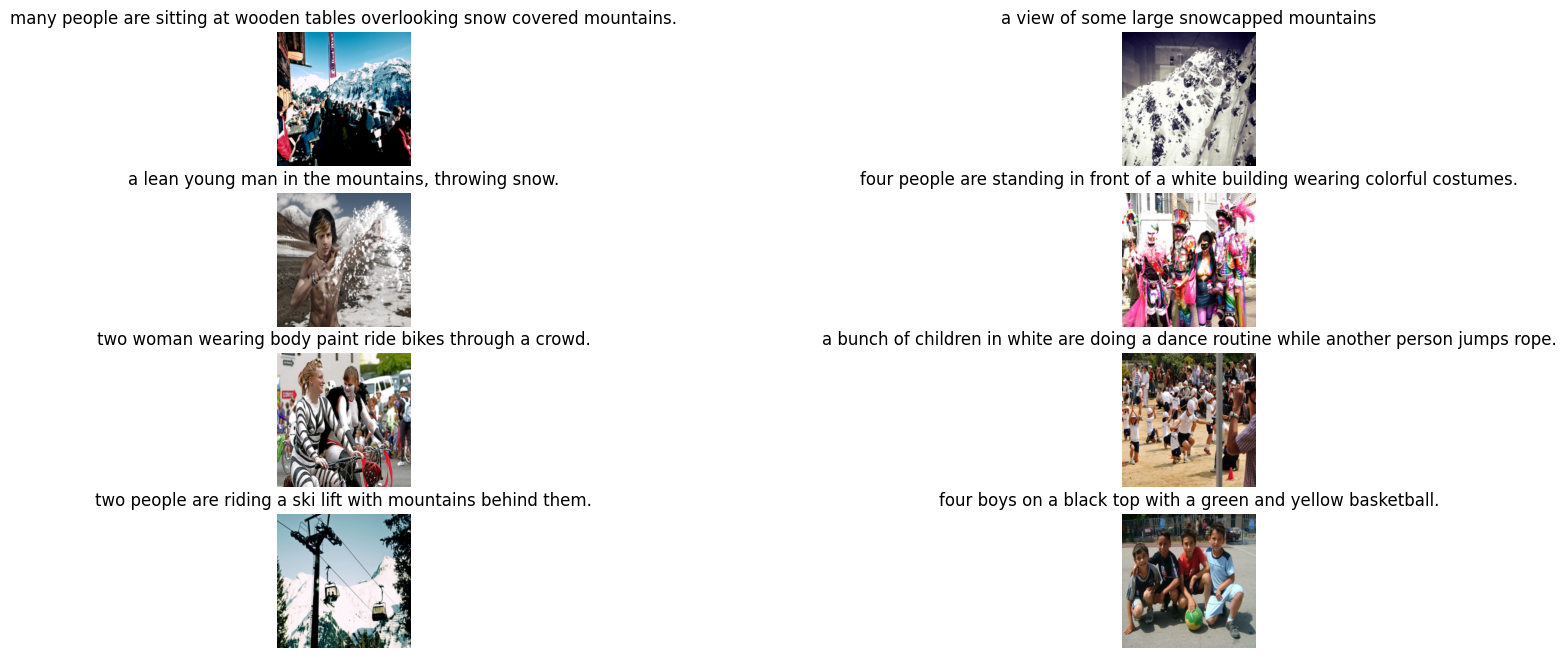

In [29]:
fig, axs = plt.subplots(4, 2, figsize=(20, 8))
for idx in range(len(matched_imgs)):
    img = matched_imgs[idx]["image"]
    label = matched_imgs[idx]["input_ids"]

    img = reverse_transform(img)
    ax = axs[idx // 2, idx % 2]
    ax.imshow(img)
    ax.set_title(tokenizer.decode(label, skip_special_tokens=True))
    ax.axis("off")

plt.show()
